In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from math import ceil

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D,\
    Dropout, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# Load data

In [2]:
images = np.load('images.npy')
targets = np.load('targets.npy')

In [3]:
unique_classes = np.unique(targets)
# class name -> integer
encode = {n: i for i, n in enumerate(unique_classes)}
# integer -> class name
decode = {i: n for i, n in enumerate(unique_classes)}

In [4]:
# encode class names by integers
targets = np.array([encode[n] for n in targets], dtype='int32')
targets_onehot = to_categorical(targets)

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(
    images, targets_onehot, 
    test_size=0.2, stratify=targets
)
print(len(X_train), len(X_test))

18317 4580


# Try a basic input pipeline

In [6]:
data_generator = ImageDataGenerator(
    rotation_range=45, 
    horizontal_flip=True, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1.0/255.0, data_format='channels_last'
)

train_generator = data_generator.flow(
        X_train, Y_train,
        batch_size=15
)

# get batch
pictures, classes = train_generator.next()

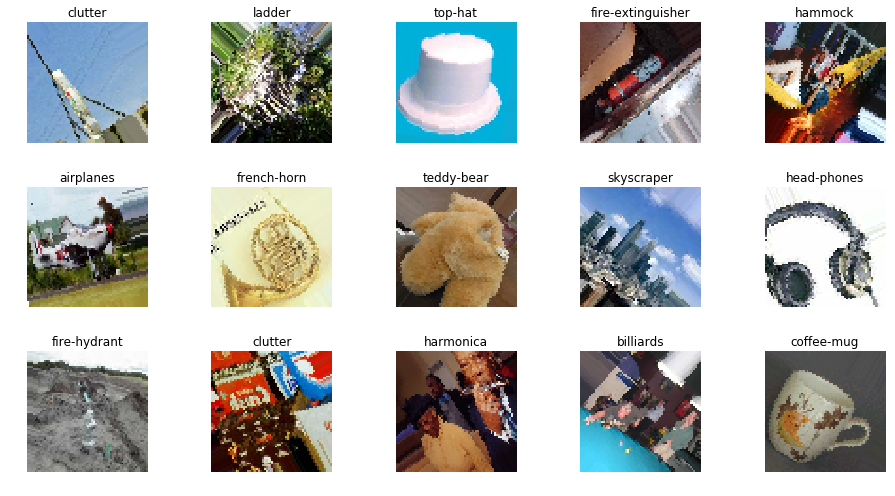

In [7]:
_, axes = plt.subplots(nrows=3, ncols=5, figsize=(13, 7))
axes = axes.flatten()
for i, pic in enumerate(pictures):
    axes[i].set_axis_off();
    axes[i].imshow(pic);
    axes[i].set_title(decode[classes[i].argmax()]);
plt.tight_layout()

# Input pipeline

In [8]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255.0
X_test /= 255.0

# standardize: featurewise_mean = 0, featurewise_std = 1
X_test -= X_train.mean(0)
X_test /= X_train.std(0)

X_train -= X_train.mean(0)
X_train /= X_train.std(0)

In [9]:
batch_size = 128
len(X_train)/batch_size

143.1015625

In [10]:
data_generator = ImageDataGenerator(
    rotation_range=45, 
    horizontal_flip=True, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    data_format='channels_last'
)

train_generator = data_generator.flow(
        X_train, Y_train,
        batch_size=batch_size
)

# "same" padding calculator

In [11]:
in_height, in_width = 64, 64
strides = (2, 2)
kernel_size = (5, 5)

In [12]:
out_height = ceil(in_height/strides[0])
out_width  = ceil(in_width/strides[1])
print(out_height, out_width)

32 32


In [13]:
pad_along_height = max((out_height - 1)*strides[0] + kernel_size[0] - in_height, 0)
pad_along_width = max((out_width - 1)*strides[1] + kernel_size[1] - in_width, 0)
print(pad_along_height, pad_along_width)

3 3


In [14]:
pad_top = pad_along_height//2
pad_bottom = pad_along_height - pad_top
pad_left = pad_along_width//2
pad_right = pad_along_width - pad_left
print(pad_top, pad_bottom, pad_left, pad_right)

1 2 1 2


# Model

In [15]:
input_shape = (64, 64, 3) 
num_classes = 257

In [16]:
# comments after layers - layer's output shape
model = Sequential([
    Conv2D(
        16, (5, 5), strides=(2, 2), padding='same', 
        kernel_initializer='he_uniform', use_bias=False, 
        input_shape=input_shape
    ), # 32, 32, 16
    BatchNormalization(scale=False),
    Activation('relu'),
    
    Conv2D(
        32, (3, 3), padding='same', 
        kernel_initializer='he_uniform', use_bias=False
    ), # 32, 32, 32  
    BatchNormalization(scale=False),
    Activation('relu'),
    
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'),  # 16, 16, 32
    Dropout(0.2),

    Conv2D(
        32, (1, 1), padding='same', 
        kernel_initializer='he_uniform', use_bias=False
    ), # 16, 16, 32
    BatchNormalization(scale=False),
    Activation('relu'),
    
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'), # 8, 8, 32
    Dropout(0.2),
    
    Flatten(), # 8*8*32 = 2048
    Dense(512, kernel_initializer='he_uniform'), # 512
    Activation('relu'), 
    Dropout(0.2),
    Dense(num_classes, kernel_initializer='he_uniform'), # 257
    Activation('softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
)

model.count_params()

1188001

In [17]:
%%time
model.fit_generator(
        train_generator,
        steps_per_epoch=400,
        epochs=20,
        validation_data=(X_test, Y_test)
);

Epoch 1/20
400/400 [==============================] - 44s - loss: 4.9905 - acc: 0.1037 - val_loss: 4.5736 - val_acc: 0.1406
Epoch 2/20
400/400 [==============================] - 43s - loss: 4.4686 - acc: 0.1460 - val_loss: 4.1846 - val_acc: 0.1801
Epoch 3/20
400/400 [==============================] - 43s - loss: 4.2398 - acc: 0.1685 - val_loss: 4.0744 - val_acc: 0.1961
Epoch 4/20
400/400 [==============================] - 43s - loss: 4.1117 - acc: 0.1812 - val_loss: 4.0118 - val_acc: 0.2059
Epoch 5/20
400/400 [==============================] - 43s - loss: 4.0299 - acc: 0.1893 - val_loss: 3.8961 - val_acc: 0.2253
Epoch 6/20
400/400 [==============================] - 43s - loss: 3.9564 - acc: 0.1979 - val_loss: 3.8467 - val_acc: 0.2345
Epoch 7/20
400/400 [==============================] - 43s - loss: 3.9045 - acc: 0.2026 - val_loss: 3.8298 - val_acc: 0.2384
Epoch 8/20
400/400 [==============================] - 43s - loss: 3.8603 - acc: 0.2111 - val_loss: 3.7610 - val_acc: 0.2441
Epoch 9/